## SF Fireshed Model Prep
Here we develop the geospatial and tabular inputs required to drive the simulations.

### Load required libraries
A bit overkill at the moment -- will thin this down prior to finalization

In [3]:
# Load required libraries and establish data directories

# ------- Notebook config
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib

# ------- Load dependencies
import pandas as pd
import numpy as np
import seaborn as sns
import gdal, os, osr
from scipy import stats
import random, ast, csv, math

# ---- Map dependencies
import fiona
from shapely.geometry import Point, Polygon, MultiPoint, MultiPolygon
from shapely.prepared import prep
from descartes import PolygonPatch
from itertools import chain
from mpl_toolkits.basemap import Basemap
from matplotlib.collections import PatchCollection

# ---- Geospatial utilities
from geoUtils import *

dataDir = 'V:/SFFireshed/'
rasters = dataDir + 'InputRasters/'

sns.set_style("ticks")
sns.set_context('notebook', font_scale=1.5)

### Define the analysis extent
and look at the extent in the context of the greater geographic area. 
The SF fireshed, as its being modeled here, is roughly 43,000 ha, and contains vegetation types
ranging from Pinon-Juniper woodlands at the lower elevations, transitioning to Ponderosa Pine 
and ultimately, up to mixtures of sub-alpine fir and Engleman Spruce at higher elevations.

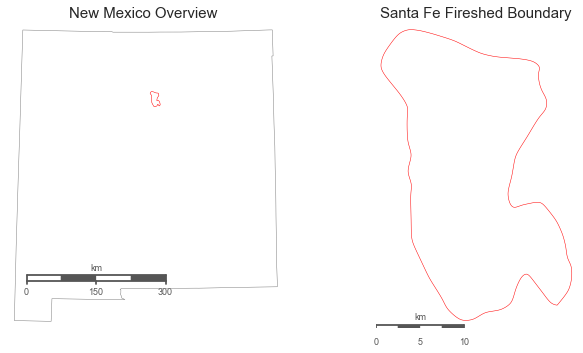

In [4]:
f, (ax1, ax2) = plt.subplots(1,2, figsize = (10,5))
coords, midlat, midlon = getShpGeom(dataDir + 'NM_NAD83.shp')

m = Basemap(llcrnrlon=coords[0],llcrnrlat=coords[1],
            urcrnrlon=coords[2],urcrnrlat=coords[3],
             resolution='i', projection='tmerc', 
            lat_0 = midlat, lon_0 = midlon, ax = ax1);

m.readshapefile(dataDir + 'NM_NAD83', 'NewMexico',
    color='gray', zorder=5);
m.readshapefile(dataDir + 'GSFCC_Boundary_NAD83', 'SFFireshed',
    color='red', zorder=5);

m.drawmapscale(
    coords[0]+2, coords[1]+1,
    coords[0], coords[1],
    300.,
    barstyle='fancy', 
    labelstyle='simple',
    fillcolor1='w', 
    fillcolor2='#555555',
    fontcolor='#555555',
    zorder=1);

coords, midlat, midlon = getShpGeom(dataDir + 'GSFCC_Boundary_NAD83.shp')

m1 = Basemap(llcrnrlon=coords[0],llcrnrlat=coords[1],
            urcrnrlon=coords[2],urcrnrlat=coords[3],
             resolution='i', projection='tmerc', 
            lat_0 = midlat, lon_0 = midlon, ax = ax2);

m1.readshapefile(dataDir + 'GSFCC_Boundary_NAD83', 'GSFCC',
    color='red', zorder=5);

m1.drawmapscale(
    coords[0] + 0.055, coords[1] + 0.00,
    coords[0], coords[1],
    10.,
    barstyle='fancy', 
    labelstyle='simple',
    fillcolor1='w', 
    fillcolor2='#555555',
    fontcolor='#555555',
    zorder=1);

ax1.set_title('New Mexico Overview', fontsize = 15)
ax2.set_title('Santa Fe Fireshed Boundary', fontsize = 15)
plt.tight_layout()
sns.set_style('white')
sns.despine(left = True, bottom = True)

### Ecoregion creation
LANDIS-II requires the landscape be separated into edaphically and climatically distinct chunks. For this study we used STATSGO and USGS data to delineate the landscape into areas of unique soil composition, and distinct elevation bands that follow clear ecotones across the landscape. The logic here being that vegetation transitions and climate are well correlated with elevation across this fireshed. We then joined the soils components with the elevation bands to create the unique ecoregions for the fireshed.

Soils data were created using STATSGO (citation) data ....

Elevation bins were generated by looking at the intersection of 300 meter elevation contours across the fireshed (DEM downloaded from https://datagateway.nrcs.usda.gov/), and the distribution of forest types based on the Southwest Regional Gap Classification (downloaded from http://swregap.nmsu.edu/)

#### Import and fix up the raster data
I classified elevation (binned into four distinct bands that correlate with vegetation ecotones) on a scale of 100 to 400. These thematic lables correspond to XX, XX, XX, and XX meter elevation contours. In this manner, the six distinct soil types (here represented as values 1-6, described below) can be crossed with each elevation band to create unique soil, elevation combinations -- here referred to as ecoregions.

Down the line realized we had some small random elevation snippets in the northwest of the landscape -- so we have to remove those and fold them into the elevation band above it. Then we have to fix up the ecoregions that were generated as a result of those elevation bins too, by taking regions 105 and 106 and making them 201.

In [21]:
elevation  = importRaster(rasters + 'elevationBins.tif')
soils      = importRaster(rasters + 'soilBins.tif')
ecoregions = importRaster(rasters + 'SFF_ecoregions.tif')

soils[soils == 255] = 0

# Change the low elevation class to match the class above it
elevation[elevation == 100] = 200

# Change the low elevation class to match the class above it
ecoregions[ecoregions == 105] = 205
ecoregions[ecoregions == 106] = 205
ecoregions[ecoregions == -9999] = 0

# Save the result
saveAsGeoTiff(rasters + 'SFF_initialcommunities.tif',
              elevation, rasters + 'SFF_FireRegions.tif', 32613)

# Save the result
saveAsGeoTiff(rasters + 'SFF_initialcommunities.tif',
              ecoregions, rasters + 'SFF_ecoregionsV2.tif', 32613)

ecoregions = importRaster(rasters + 'SFF_ecoregionsV2.tif')


We need to do some color map trickery in order to visualize the ecoregions here, given that the thematic values are discontinuous and range from 105-406, with a sort of macro/micro class setup that I designed to make the raster math simple

In [22]:
from matplotlib import colors
cmap = colors.ListedColormap(['white','#969696','#636363',
                              '#edf8e9','#c7e9c0','#a1d99b','#74c476','#31a354','#006d2c',
                              '#f2f0f7','#dadaeb','#bcbddc','#9e9ac8','#756bb1','#54278f',
                              '#eff3ff','#bdd7e7','#6baed6','#3182bd','#08519c'])
bounds=[0,105,106,
        201,202,203,204,205,206,
        301,302,303,304,305,306,
        401,402,403,404,406]
norm = colors.BoundaryNorm(bounds, cmap.N)

In [23]:
np.unique(ecoregions)

array([   0.,  201.,  202.,  203.,  204.,  205.,  206.,  301.,  302.,
        303.,  304.,  305.,  306.,  401.,  402.,  403.,  404.,  406.])

####Visualize the three rasters 

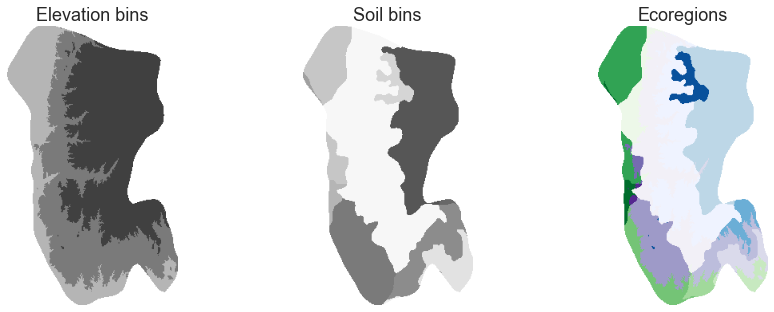

In [24]:
f, (ax1, ax2, ax3) = plt.subplots(1,3, figsize = (15,5))
plotRaster(elevation,  vmin = 0, vmax = 500, ax = ax1)
plotRaster(soils,      vmin = 0, vmax = 15,  ax = ax2)
plotRaster(ecoregions, cmap = cmap, norm = norm, ax = ax3)
ax1.set_title('Elevation bins')
ax2.set_title('Soil bins')
ax3.set_title('Ecoregions')

### Initial communities
A second major challenge to initializing the modeling environment for LANDIS-II simulations is the creation of an initial communities layer. This raster is a spatial lookup table for the species and age demographics in each pixel. 

We used the southwest regional gap classification to bin the landscape into three dominant cover types: Pinon-juniper woodlands, ponderoda pine, and mixed conifer ecosystems. Within these bins, we ran independent generalized nearest neighbor imputations to predict FIA plot data given stacks of elevation, slope, and tasseled cap transformation rasters from a greenest pixel Landsat 8 composite.

--- info regarding TC raster creation <p>
--- GNN model info (CCA or RF?)

We developed age-diameter relationships for each species in the watershed represented in FIA plots. When then used these relationships on a per FIA plot basis to associate each pixel with a set of species and age cohorts. The results of the initial communities generation is shown below:

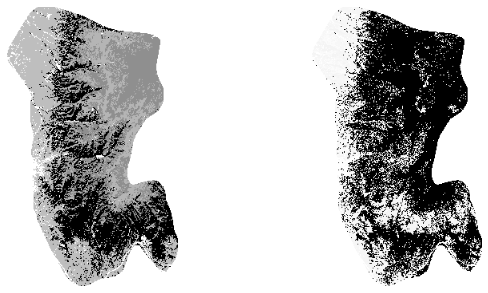

In [19]:
fortype  = importRaster(rasters + 'SFF_initialforesttypes.tif')
SFFic    = importRaster(rasters + 'SFF_initialcommunities.tif')

f, (ax1, ax2) = plt.subplots(1,2, figsize = (10,5))
plotRaster(fortype, vmin = 0, vmax = 500, ax = ax1)
plotRaster(SFFic,   vmin = 0, vmax = 500, ax = ax2)

### Looks like the data types of the IC raster are incorrect
and we need to re-export them as float or int. I'm going to stick with int, so things are consistent with other LANDIS extensions. GDT_Int32 normally handles everything we need to do well. There are also some hidden no-data values associated with the raster being created with an incorrect tif dtype -- these sorts of errors are especially troubling in modeling environments like this. A handy way to root them out however is to look at the unique values in what should be a discrete raster.

In [ ]:
np.unique(SFFic)

### What we can see is the classic -3.4*10^39
craziness that I associated with a 32 bit tif. Easy fix though, we want those values to be replaced with zeros, and for the whole rasters dtype to be GDT_Int32.

In [ ]:
def saveAsGeoTiff(spatialRaster, ndarray, outputFileName, epsg):
    templatedf = gdal.Open(spatialRaster)
    template = templatedf.ReadAsArray()
    driver = gdal.GetDriverByName('GTiff')
    outputRaster = driver.Create(outputFileName,
                                 template.shape[1],
                                 template.shape[0],
                                 1, gdal.GDT_Int16)
    
    srs = osr.SpatialReference()
    srs.ImportFromEPSG(epsg)
    dest_wkt = srs.ExportToWkt()
    
    outputRaster.SetGeoTransform(templatedf.GetGeoTransform())
    outputRaster.GetRasterBand(1).WriteArray(ndarray)
    outputRaster.SetProjection(dest_wkt)

    outputRaster.FlushCache()

In [20]:
SFFic[SFFic < -0] = 0

saveAsGeoTiff(rasters + 'SFF_initialcommunities.tif',
              SFFic, rasters + 'SFF_initialcom.tif', 32613)

### Climate configuration
Before we can spin up the model, we need to build  the climate files that will drive the growth and succession of the vegetation across the landscape. These files are specific to each ecoregion, and in the LANDIS-II PnET extension, the climate library afforded by other succession extensions is thrown to the wayside. That means we need a separate text file for each ecoregion. <p>

I chose to use LOCA statistical downscaling products based on CMIP5 projections. These can be downloaded using the climate data portal: https://cida.usgs.gov/gdp/. For more info on the LOCA project: http://loca.ucsd.edu/. <p>

The PnET extension also requires monthly average PAR and atmospheric [CO2]. This compounds the pain of assembling climate data, since there is no one stop shop for downscaled climate, PAR, and [CO2]. I chose to make use of shortwave radiation from Daymet (http://dx.doi.org/10.3334/ORNLDAAC/1328), and [CO2] from Mauna Loa (https://www.esrl.noaa.gov/gmd/ccgg/trends/data.html). <p>

So, the workflow here will be to use the same [CO2] and radiation time series for each LOCA projection, and have the projections Tmin, Tmax, and Precip provide the variability for growth and succession  over time.

In [ ]:
# Start and grab the SW data, subset it to only grab mean values
simDir  = 'V:/SF_Fireshed_PnET_Sims/'
SW      = pd.read_csv(simDir + 'DAYMET_SW.csv', skiprows=1)
SWmu    = SW.loc[:, 'TIMESTEP':'MEAN(W/m2).18']

# Create an array of column headers
headers =['Time','105','106','201','202','203','204','205',
         '206','301','302','303','304','305','306','401',
         '402','403','404','406']
SWmu.columns = headers

# Read in the [CO2] data
CO2 = pd.read_csv(simDir + 'NOAA_CO2.csv', sep = ',')

# Read in the climate projection
loca_clim = pd.read_csv(simDir +'Access_Historical.csv', skiprows=2)
climdf    = loca_clim.dropna()

# Gather the index locations for the variable transition in the CDP files
# Here I'm using the repeated column header as an indication. 
varrows   = climdf[climdf['TIMESTEP'].str.match('TIMESTEP')]
precip    = climdf[:varrows.index[0]-2]
tamax     = climdf[varrows.index[0]-1:varrows.index[1]-4]
tamin     = climdf[varrows.index[1]-3:]

# Now we have to compute the monthly means from the daily vaules
# This means creating a timestamp as well.
#for df in [precip, tamax, tamin]:
#    df.columns = headers
#    df.index = pd.to_datetime(df.Time)
#    df = df.drop('Time', axis = 1).astype('float')

# ugly short term fix, will need a function workflow here
precip.columns = headers
precip.index = pd.to_datetime(precip.Time)
precip = precip.drop('Time', axis = 1).astype('float')
tamax.columns = headers
tamax.index = pd.to_datetime(tamax.Time)
tamax = tamax.drop('Time', axis = 1).astype('float')
tamin.columns = headers
tamin.index = pd.to_datetime(tamin.Time)
tamin = tamin.drop('Time', axis = 1).astype('float')
SWmu.index = pd.to_datetime(SWmu.Time)

precip['Year'] = tamax.index.year
precip['Month'] = tamax.index.month
tamax['Year'] = tamax.index.year
tamin['Year'] = tamin.index.year
tamax['Month'] = tamax.index.month
tamin['Month'] = tamin.index.month
SWmu['Month'] = SWmu.index.month
SWmu['Year']  = SWmu.index.year

pr   = precip.reset_index(drop=True)
tmax = tamax.reset_index(drop=True)
tmin = tamin.reset_index(drop=True)

prmu   = pr.groupby(['Year','Month']).sum().reset_index()
tmaxmu = tmax.groupby(['Year','Month']).mean().reset_index()
tminmu = tmin.groupby(['Year','Month']).mean().reset_index()
SWMmu  = SWmu.groupby(['Year','Month']).mean().reset_index()

### Now we need to create distributions of PAR from the shortwave 
data that we have. We need to populate the longer time series of the LOCA data with the shorter daymet shortwave. We also have to convert the shortwave data to an estimate of the portion of that radiation that is PAR. We're going to use a simple scalar to convert SW to PAR, and make the assumption that interanual variability PAR in an area is not changing signifncantly over the simulation period. The coefficients and explanation can be found here: <p>
Britton, C. M., and J. D. Dodd. Relationships of photosynthetically active radiation and shortwave irradiance. Agricultural Meteorology 17, no. 1 (1976): 1-7. 

In [ ]:
earlyPad = SWMmu[SWMmu.Year < 2010]
earlyPad = earlyPad.ix[:, earlyPad.columns != 'Year']
earlyPad = earlyPad.ix[:, earlyPad.columns != 'Month']

yearMonth = prmu[prmu.Year <= 1979][['Year','Month']]
earlySW = pd.concat([earlyPad, yearMonth], axis = 1)
allSW = pd.concat([earlySW, SWMmu[SWMmu.Year < 2006]]).reset_index()
allCO2 = CO2[CO2.year < 2006].CO2

### Now we have to compile the component climate columns
into a text file that PnET requires

In [ ]:
allecos =['105','106','201','202','203','204','205',
         '206','301','302','303','304','305','306','401',
         '402','403','404','406']

for eco in allecos:
    climname = 'ACCESS_HIST'
    ecodf = pd.DataFrame(dict(Year = tminmu.Year,
                      Month = tminmu.Month, 
                      TMax = tmaxmu[eco], 
                      TMin = tminmu[eco],
                      PAR  = allSW[eco],
                      PREC = prmu[eco],
                      CO2 = allCO2))
    ecodf = ecodf.round(2)[['Year','Month','TMax','TMin','PAR','PREC','CO2']]
    ecodf.Year[ecodf.Year == 1950] = '1600-1950'
    ecodf.Year[ecodf.Year == 2005] = '2005-2050'

    eco_climname = 'SFF_' + climname + '_' + eco + '.txt'
    ecodf.to_csv(eco_climname, sep = '\t', index = False)

### Fire size distribution parameterization
I grabbed fire perimeter data from GeoMAC here: https://rmgsc.cr.usgs.gov/outgoing/GeoMAC/historic_fire_data/, and clipped the data to encompass the Valles west Valles Caldera and Bandelier regions and the SFForest area on the eastern side of US 25. 

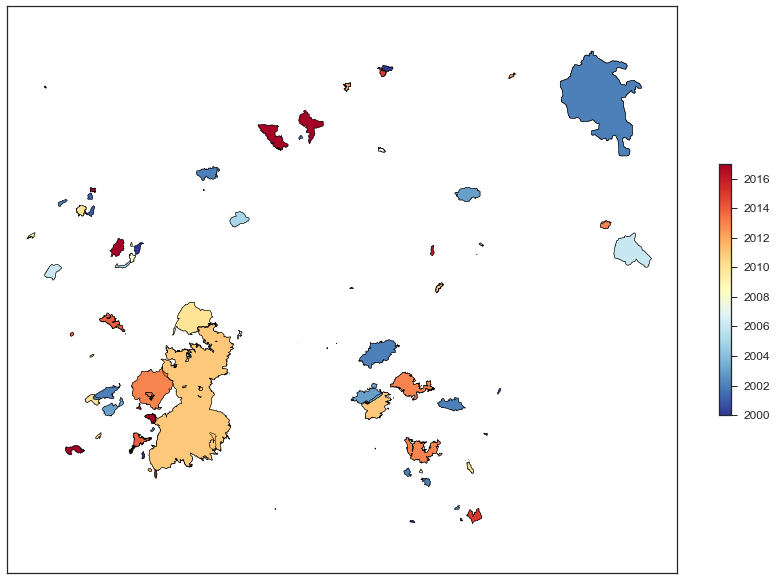

In [58]:

f, (ax) = plt.subplots(1,1, figsize = (15,15))
coords, midlat, midlon = getShpGeom(dataDir + 'HistoricFirePerimeters.shp')

m = Basemap(llcrnrlon=coords[0],llcrnrlat=coords[1]+3.5,
            urcrnrlon=coords[2],urcrnrlat=coords[3],
             resolution='i', projection='tmerc', 
            lat_0 = midlat, lon_0 = midlon, ax = ax);

m.readshapefile(dataDir + 'HistoricFirePerimeters', 'FireRegion',
    color='black', zorder=5);

# set up a map dataframe
fireregion = []
df_map = pd.DataFrame({
    'poly': [Polygon(xy) for xy in m.FireRegion]})
for shape in enumerate(df_map['poly']):
    keys, values = m.FireRegion_info[shape[0]].keys(),m.FireRegion_info[shape[0]].values()
    fireregion.append(values[1])
df_map['FireRegion'] = fireregion
df_map['area_m'] = df_map['poly'].map(lambda x: x.area)
df_map['area_km'] = df_map['area_m'] / 100000
df_map['patches'] = df_map['poly'].map(lambda x: PolygonPatch(
    x, ec='#787878', lw=.25))

fireregion = map(int, fireregion)
#for feature in np.unique(df_map.FireRegion):
p = PatchCollection(df_map.patches,cmap=plt.get_cmap('RdYlBu_r'))
p.set_array(np.array(fireregion))
p.set_clim([np.ma.min(fireregion),np.ma.max(fireregion)])
cbar = plt.colorbar(p, shrink = 0.3)
cbar.ax.tick_params(labelsize=12)
ax.add_collection(p)
plt.show()

sns.despine()

C:\Anaconda\lib\site-packages\IPython\kernel\__main__.py:10: RuntimeWarning: divide by zero encountered in log
C:\Anaconda\lib\site-packages\IPython\kernel\__main__.py:11: RuntimeWarning: divide by zero encountered in log
C:\Anaconda\lib\site-packages\IPython\kernel\__main__.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


scatter for data is 1.7449947611 when modeled and nan from data
mean of data is 5.1070492804 when modeled and -inf from data
maximum fire size from the data in hectares: 63396.096261


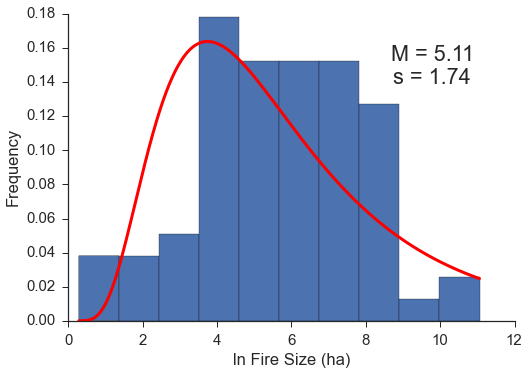

In [67]:
from scipy import stats
# Derive the mu and sigma params from CALFIRE data directly
# in LANDIS-II DFFS, mu and sigma are the location of mean and sd
# of the lognormal distributions -- therefore, we can do two things... 
# either take the mean of the natural log of the data, or fit a lognormal
# distribution to the log transformed data.
metadata = pd.read_csv(dataDir + 'SFFHistory.csv')
# Data driven approach:
metadata['HECTARES'] = metadata.acres * 0.404686
firesizeMu = np.log(metadata.HECTARES).mean()
firesizeSd = np.log(metadata.HECTARES).std()
# Modeled approach:
# Limit fires to those > 1 ha
metadata.HECTARES[metadata.HECTARES < 1] = np.nan
firesize = np.log(metadata.HECTARES).dropna()
rvs = firesize # Generate some random variates as data
n, bins, patches = plt.hist(rvs, bins=10, normed=True) # Plot histogram

shape, loc, scale = stats.lognorm.fit(rvs, floc=0) # Fit a curve to the variates
mu = np.log(scale) # Mean of log(X)
sigma = shape # Standard deviation of log(X)
M = np.exp(mu) # Geometric mean == median
s = np.exp(sigma) # Geometric standard deviation

# Plot figure of results
x = np.linspace(rvs.min(), rvs.max(), num=400)
plt.plot(x, stats.lognorm.pdf(x, shape, loc=0, scale=scale), 'r', linewidth=3) # Plot fitted curve
ax = plt.gca() # Get axis handle for text positioning
txt = plt.text(0.9, 0.9, 'M = %.2f\ns = %.2f' % (M, s), horizontalalignment='right', 
                size='large', verticalalignment='top', transform=ax.transAxes)
ax.set_ylabel('Frequency')
ax.set_xlabel('ln Fire Size (ha)')

sns.despine()
print "scatter for data is %s when modeled and %s from data" %(s, firesizeSd)
print "mean of data is %s when modeled and %s from data" %(M, firesizeMu)  
print "maximum fire size from the data in hectares: %s" %metadata.HECTARES.max()

### Have to create a quick slope and azimuth layer for the fire model
These apparently were not generated correctly the first time, so we're gonna take a peek at them here and see whats goin on.

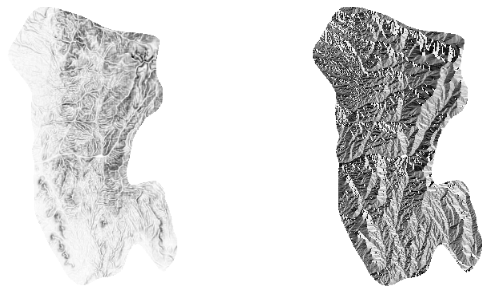

In [60]:
# Import the new saved file
slope   = importRaster(rasters + 'SFF_Slope.tif')
azimuth = importRaster(rasters + 'SFF_Azimuth_trad.tif')

# Plot it
f, (ax1, ax2) = plt.subplots(1,2, figsize = (10,5))
plotRaster(slope,    vmin = 0, vmax = 90, ax = ax1)
plotRaster(azimuth,  vmin = 0, vmax = 360, ax = ax2)


### Neither of the files were the right dimensions ...
and the Azimuth file had some issues. Apart from file type, which precluded the DFFS from processing it correctly, the raster also does not have the necessary perspective. Currently, as most traditional azimuth rasters do, the surface describes slope aspect, or downhill azimuth. The DFFS requires uphill azimuth, which means we need to convert the 360 degree data appropriately, and recrearte the raster.

I've already got some code that does this operation on a list, for converting wind directions (which LANDIS also needs to be reversed from the widely adopted convention ...). We can just use that code for every cell in the traditional azimuth raster. The trick here is to vectorize the function first, then each element of the input raster will be read in like a vector would, removing the external loop requirements (e.g., azimuth[i,j] etc). Pretty slick trick.

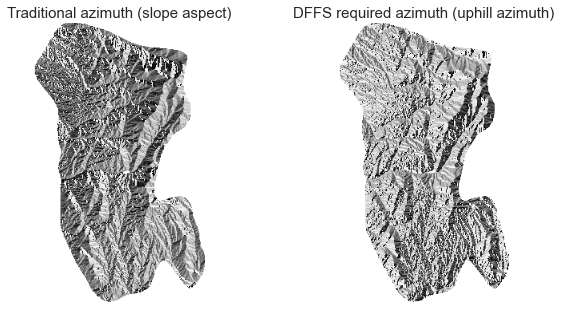

In [66]:
uphillAZ = np.vectorize(adjustWindAz, otypes=[np.float])  

uphill_azimuth = uphillAZ(azimuth)  

f, (ax1, ax2) = plt.subplots(1,2, figsize = (10,5))
plotRaster(azimuth,    vmin = 0, vmax = 360, ax = ax1)
plotRaster(uphill_azimuth,  vmin = 0, vmax = 360, ax = ax2)

ax1.set_title('Traditional azimuth (slope aspect)', fontsize = 15)
ax2.set_title('DFFS required azimuth (uphill azimuth)', fontsize = 15)

saveAsGeoTiff(rasters + 'SFF_initialcommunities.tif',
              uphill_azimuth, rasters + 'SFF_uphillazimuth.tif', 32613)


### We also need to specify a fire region layer
for the fireshed. Elevation bins makes the most sense here, given that there is a strong relationship between elevation and vegetation type, and elevation and fireweather. The only problem here is that there are elevation bins in the northwest corner that should be lumped into the broader low elevation fire region. Thats a quick fix.

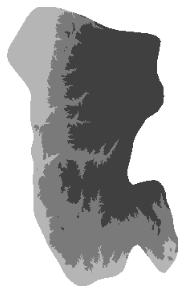

In [101]:
# Change the low elevation class to match the class above it
elevation[elevation == 100] = 200

# Save the result
saveAsGeoTiff(rasters + 'SFF_initialcommunities.tif',
              elevation, rasters + 'SFF_FireRegions.tif', 32613)

# Import the new saved file
fireregions = importRaster(rasters + 'SFF_FireRegions.tif')

# Plot it
f, (ax1) = plt.subplots(1,1, figsize = (15,5))
plotRaster(fireregions,  vmin = 0, vmax = 500, ax = ax1)


### Processing up fire weather for the SF Fireshed
starts with grabbing RAWS data from stations close to the study region. The aptly named 'Santa Fe Fireshed RAWS station' appears to be bunk, so I'm using data from the Pecos RAWS station, which is pretty close. 

We need three different sites, based on the rough elevation of our fire regions. The Pecos RAWS station sits at 2620m. The Coyote RAWS comes in at 2680, and Mountainair NM is at 1981 meters. It would be nice to have slightly higher elevation for both the low and high elevation fire regions, but the data should be sufficient -- Mountainair is pretty far south of the study area, but I have spent several years studying PJ dynamics down there and consider it a representative depiction of the climatic and vegetation dynamics that I associate with PJ in the state.

In [44]:

def adjustWindAz(windDir):
    if math.degrees(math.radians(windDir) + math.radians(180)) > 360:
        windDir_adj = math.degrees(math.radians(windDir) + math.radians(180)) - 360
    else:
        windDir_adj = math.degrees(math.radians(windDir) + math.radians(180))
    return windDir_adj
        
# Function to clean up the mask values and data types from the RAWS outputs. Note, here the RAWS ASCII Downloads
# have to be manually edited to conform to the sample input from Louise's script in order to run.

def cleanRaws(formattedRawsData, maskValue, yearStart, yearStop, cleanedRawsData, windFix):
    rawsdata = pd.read_csv(formattedRawsData)
    rawsdata[rawsdata == maskValue] = np.nan
    rawsdata = rawsdata.dropna()
    rawsdata.Juliandate = rawsdata.Juliandate.astype(int)
    if windFix == 'yes':
        print 'Converting wind directions.....'
        rawsdata.windazimuth = rawsdata.windazimuth.apply(adjustWindAz) # wind direction adjustment
    rawsdata.windazimuth = rawsdata.windazimuth.astype(int)
    rawsdata.relativehumidity = rawsdata.relativehumidity.astype(int)
    rawsdata = rawsdata[rawsdata.year > yearStart]
    rawsdata = rawsdata[rawsdata.year < yearStop]
    if windFix == 'yes':
        rawsdata.windspeed = rawsdata.windspeed * 3.6 # Convert m/s to km/h

    rawsdata.to_csv(cleanedRawsData, index = False)

Converting wind directions.....


C:\Anaconda\lib\site-packages\IPython\kernel\__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


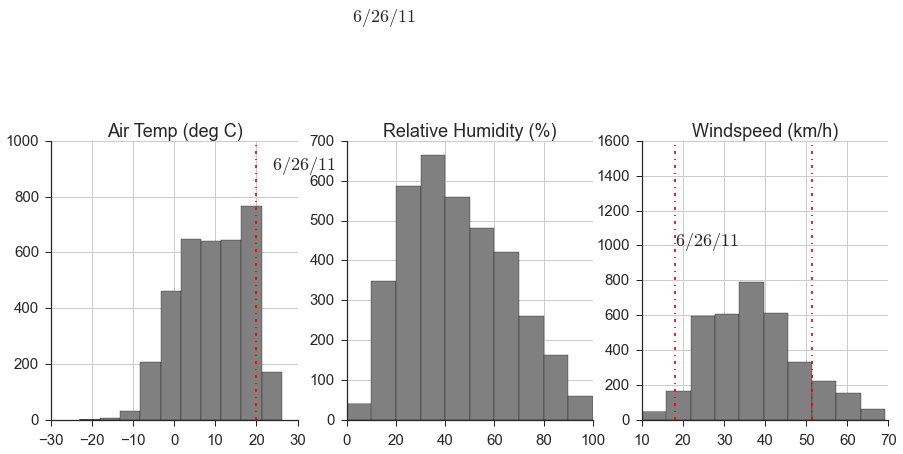

In [92]:
cleanRaws(dataDir + 'PecosRAWS.csv', -9999, 2005, 2016,dataDir + 'cleanedPecosRAWS.csv', 'yes')  
osceolaraws = pd.read_csv(dataDir + 'cleanedPecosRAWS.csv')
osceolaraws.windspeed[osceolaraws.windspeed > 70] = 10
f, (ax1, ax2, ax3) = plt.subplots(1,3, figsize = (15,5))
osceolaraws.temp.hist(ax = ax1, color = 'gray')
osceolaraws.relativehumidity.hist(ax = ax2, color = 'gray')
osceolaraws.windspeed.hist(ax = ax3, color = 'gray')

ax1.set_title('Air Temp (deg C)')
ax2.set_title('Relative Humidity (%)')
ax3.set_title('Windspeed (km/h)')

ax1.vlines(osceolaraws.temp.quantile(.90), 0, 1000, linestyle = '-.', color = 'red')
#ax2.vlines([osceolaraws.relativehumidity.quantile(.10), 30], 0, 1200, linestyle = '-.', color = 'red')
ax3.vlines([osceolaraws.windspeed.quantile(.90), 18], 0, 1600, linestyle = '-.', color = 'red')

ax1.text(23.8, 900, r'$6/26/11$')
ax2.text(2, 1000, r'$6/26/11$')
ax3.text(18, 1000, r'$6/26/11$')


sns.despine()
sns.set_style('ticks')

### Now that we have fire weather for all three elevations
or fire regions, we need to step through each region's RAWS data and create decadal distributions of increasing fire weather severity.

In [ ]:
pecentiles = [0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95]
percentileMap = ['#a50026','#d73027','#f46d43','#fdae61','#fee090','#e0f3f8','#abd9e9','#74add1','#4575b4','#313695']
FireRegions = ['FR1','FR2','FR3']

regionIDX = 0
allWindsIDX = 0
for FR in [FR1, FR2, FR3]:
    
    # Add in some years of severe wind data
    FR_winds = FR.windspeed.append(FRS[FRS.year >= 2010].windspeed)
    
    # Calculate the CDF of our distribution
    sortedWind = np.sort(FR_winds)
    p = 1. * np.arange(len(sortedWind)) / (len(sortedWind) - 1)

    idx = 0
    fig1 = plt.figure(figsize= (12,5))
    ax1 = fig1.add_subplot(121)
    for percent in pecentiles:

        if percent < 0.6:
            decadalMean = sortedWind[np.isclose(p, percent, rtol = 0.7)].mean()
            decadalStd = sortedWind[np.isclose(p, percent, rtol = 0.7)].std()      
        elif (percent <= 0.65) & (percent > 0.5):
            decadalMean = sortedWind[np.isclose(p, percent, rtol = 0.5)].mean()
            decadalStd = sortedWind[np.isclose(p, percent, rtol = 0.5)].std()
        elif percent == 0.7:
            decadalMean = sortedWind[np.isclose(p, percent, rtol = 0.4)].mean()
            decadalStd = sortedWind[np.isclose(p, percent, rtol = 0.4)].std()

        else: 
            decadalMean = sortedWind[np.isclose(p, percent, rtol = 0.2)].mean()
            decadalStd = sortedWind[np.isclose(p, percent, rtol = 0.2)].std()
        decadalWind = pd.DataFrame(dict(winds = np.random.normal(loc=decadalMean, scale=decadalStd, size=365 * 9)))

        count, bins, ignored = plt.hist(decadalWind.winds, 30, normed=True, alpha = 0.00)
        chanceHighWind = pd.DataFrame(dict(winds = FRS[FRS.year == random.choice(FRS.year)].windspeed))
        extremeWinds = pd.DataFrame(dict(winds = np.random.normal(loc=chanceHighWind.winds.mean(), 
                                    scale=chanceHighWind.winds.std(), size=365)))  
        decadalWind = decadalWind.append(extremeWinds)
        decadalWind = decadalWind.sample(frac=1).reset_index(drop=True)
        if allWindsIDX == 0:
            allWinds = pd.DataFrame(dict(wind = decadalWind.winds, decade = idx, 
                                         FireRegion = FireRegions[regionIDX]))
            allWinds['windIndex'] = 0

        else:
            windDF = pd.DataFrame(dict(wind = decadalWind.winds, decade = idx, 
                                       FireRegion = FireRegions[regionIDX]))
            windDF = windDF.reset_index()
            allWinds = pd.concat([allWinds, windDF])

        sns.distplot(decadalWind, color = np.flipud(percentileMap)[idx], hist=False, ax = ax1, norm_hist=True)
        idx += 1
        allWindsIDX += 1  
    allWinds.windIndex[allWinds.FireRegion == FireRegions[regionIDX]] = np.arange(0,36500)
    regionIDX += 1
    sns.despine()
    ax1.set_xlabel('Wind Speed (km hr$^{-1}$)')
    ax1.set_ylabel('Density')
    ax1.set_xlim([0,20])
    #allWinds = allWinds.reset_index()
    ax2 = fig1.add_subplot(122)
    for region in np.unique(allWinds.FireRegion):
        allWindsFR = allWinds[allWinds.FireRegion == region]
        
        for decade in np.unique(allWindsFR.decade):
            thisDecade = allWindsFR[allWindsFR.decade == decade]
            ax2.scatter(y = thisDecade.wind, x = thisDecade.windIndex,
                                color = np.flipud(percentileMap)[decade])
            ax2.set_xlim([0, 36500])
            sns.set_style('ticks')

        ax1.annotate('First decade', xy=(4.7, 0.17), xycoords='data',
                    xytext=(-50, 30), textcoords='offset points', size = 15,
                    arrowprops=dict(arrowstyle="->")
                    )
        ax1.annotate('Last decade', xy=(12, 0.21), xycoords='data',
                    xytext=(-50, 30), textcoords='offset points', size = 15,
                    arrowprops=dict(arrowstyle="->")
                    )


        ax2.set_ylabel('Wind Speed (km hr$^{-1}$)')
        ax2.set_xlabel('Simulation Decade')
        ax2.set_xticks(np.linspace(0, allWindsFR.wind.size, 11))
        ax2.set_xticklabels(['0','1','2','3','4','5','6','7','8','9','10'])
        sns.despine()

### And now we can turn those RAWS observations into fire weather
using equations from the fire behavior and prediction system

In [ ]:
from FireWeatherIndex_Calculations import DynamicFireWeatherCalculations

for region in ['FR1','FR2','FR3']:
    p = DynamicFireWeatherCalculations(dataDir + 'cleanedPecosRAWS.csv',
                                           dataDir + 'FWstartingvalues_' + region + '.csv',
                                           dataDir +  region + '_FireWeather.csv', region)
    p.run()

### Management considerations
First step is to produce a stand map

In [84]:
genStandMap(dataDir, rasters + 'SFF_initialcommunities.tif', 'SFFireshedStands.tif')

NameError: name 'genStandMap' is not defined